In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

path2add = os.path.normpath(os.path.abspath('..'))
if path2add not in sys.path: sys.path.append(path2add)

import torch
from torch_geometric.data import Data
from dataloader import GraphDataset, GraphTextDataset, TextDataset, GraphTextInMDataset, AllGraphDataset, AugmentGraphDataset, AugmentGraphTextDataset
from augment import RWSample, UniformSample
import networkx as nx

from transformers import AutoTokenizer
import numpy as np

In [3]:
tokenizer = AutoTokenizer.from_pretrained('nlpie/distil-biobert')

In [10]:
transforms = [RWSample(), UniformSample()]

def transform_augment(sample):
    tmp = sample.clone()
    if tmp.x.shape[0] > 6:
        choice = np.random.randint(2)
        transform = transforms[choice]
        tmp = transform(tmp)

    data = Data(
        x = sample.x,
        edge_index = sample.edge_index,

        x_augment = tmp.x,
        edge_index_augment = tmp.edge_index,

        input_ids = sample.input_ids,
        attention_mask = sample.attention_mask,

        description = sample.description,
    )
    return data

In [11]:
gt = np.load("../data/token_embedding_dict.npy", allow_pickle=True)[()]
train_dataset = AugmentGraphTextDataset(
    root="../data/", gt=gt, split="train", tokenizer=tokenizer, model_name='nlpie/distil-biobert', transform=transform_augment
)

In [12]:
len(train_dataset)

26408

Data(x=[20, 300], edge_index=[2, 38], x_augment=[18, 300], edge_index_augment=[2, 32], input_ids=[2, 256], attention_mask=[2, 256], description=[2])


(['Petroselaidate is an unsaturated fatty acid anion resulting from the deprotonation of the carboxy group of petroselaidic acid. The major species at pH 7.3',
  'It is a long-chain fatty acid anion and an unsaturated fatty acid anion. It is a conjugate base of a petroselaidic acid.'],
 ['Petroselaidate is an unsaturated fatty acid anion resulting from the deprotonation of the carboxy group of petroselaidic acid. The major species at pH 7. 3',
  'It is a long - chain fatty acid anion and an unsaturated fatty acid anion. It is a conjugate base of a petroselaidic acid.'])

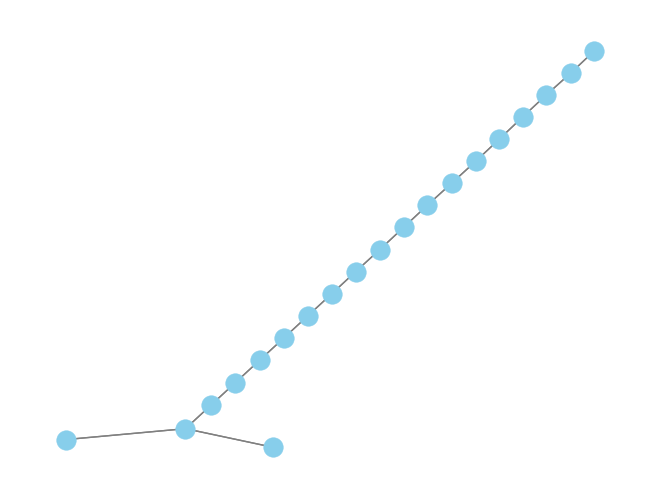

In [15]:
sample = train_dataset[9879]
print(sample)

edges = sample.edge_index
G = nx.DiGraph()
for i in range(len(edges[0])):
    G.add_edge(int(edges[0][i]), int(edges[1][i]))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=False, font_size=8, node_color='skyblue', node_size=200, edge_color='gray', linewidths=0.3, arrows=False)



sample.description, tokenizer.batch_decode(sample.input_ids, skip_special_tokens=True)

In [8]:
from torch_geometric.loader import DataLoader

batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [9]:
next(iter(train_loader))

['Dasabuvir is a member of the class of pyrimidone, which is (as the monohydrate of its sodium salt) in combination with ombitasvir, paritaprevir and ritonavir (under the trade name Viekira Pak) for treatment of chronic hepatitis C virus genotype 1 infection as well as cirrhosis of the liver', 'It has a role as an antiviral drug and a nonnucleoside hepatitis C virus polymerase inhibitor. It is a member of naphthalenes, a sulfonamide, an aromatic ether and a pyrimidone. It derives from a uracil.']
['Dasabuvir is a member of the class of pyrimidone, which is ( as the monohydrate of its sodium salt ) in combination with ombitasvir, paritaprevir and ritonavir ( under the trade name Viekira Pak ) for treatment of chronic hepatitis C virus genotype 1 infection as well as cirrhosis of the liver', 'It has a role as an antiviral drug and a nonnucleoside hepatitis C virus polymerase inhibitor. It is a member of naphthalenes, a sulfonamide, an aromatic ether and a pyrimidone. It derives from a ur

DataBatch(x=[4189, 300], edge_index=[2, 8718], x_augment=[3478, 300], edge_index_augment=[2, 6792], input_ids=[256, 256], attention_mask=[256, 256], description=[128], batch=[4189], ptr=[129])